# 回归模型

检查pycaret的版本，确保可以运行。
- 需要2.0.0及以上

注意2.2.0版本如果用 pip install pycaret安装，catboost、xgboost缺省是不装的。
本例中，安装了全集 pip install pycaret[full]

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import numpy as np
import pandas as pd

import pycaret
pycaret.__version__

'2.2.0'

## 课程内容：

- 导入数据：从PyCaret的datasets中导入数据
- 设置环境：在PyCaret中设置实验并开始构建回归模型
- 创建模型：执行交叉验证和评估回归指标
- 调整模型：自动调整回归模型的超参数（需要人为设定的参数叫做超参数）
- 结果绘图：使用各种绘图，分析模型性能
- 预测模型：对测试集进行预测


## 导入数据
使用数据集："Sarah Gets a Diamond"。数据来源于一个浪漫MBA学生(真的，没开玩笑)为自己的新娘莎拉选择合适的钻石的案例。

数据包含6000条记录。每列的简短描述如下：

    ID：每颗钻石的独一无二的编号
    Carat Weight：重量，公制克拉中钻石的重量。
    Cut：切割工艺，五个值之一(Signature-Ideal, Ideal, Very Good, Good, Fair)
    Color：颜色，六个值之一(D, E, F - Colorless, G, H, I - Near colorless)
    Clarity：净度，七个值之一(F - Flawless, IF - Internally Flawless, VVS1 or VVS2 - Very, Very Slightly Included, or VS1 or VS2 - Very Slightly Included, SI1 - Slightly Included)
    Polish：抛光度，四个值之一(ID - Ideal, EX - Excellent, VG - Very Good, G - Good)
    Symmetry：对称性，四个值之一(ID - Ideal, EX - Excellent, VG - Very Good, G - Good)
    Report：评估钻石质量的分级机构，两个值之一("AGSL", "GIA")
    Price：钻石价格

### 数据预处理
利用get_data()函数下载数据集（需要联网）

然后，我们复习一下上节课的内容：对数据处理的异常值检测。

In [16]:
from pycaret.datasets import get_data
# import pandas as pd
# dataset = get_data('diamond')

file_name='./data/diamond.csv'
dataset=pd.read_csv(file_name)
dataset

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


查看数据的形状

In [17]:
dataset.shape

(6000, 8)

模型对于文字信息的处理能力没有对数字信息强，所以，对数据的文字部分(具体说Cut,Color,Clarity,Polish,Symmetry,Report六列)，我们选择将其转化为对应数字。同时，数字信息也便于绘图和进行计算。

In [18]:
for i in dataset.columns:
    if i not in ['Carat Weight', 'Price']:
        dataset[i].replace(dataset[i].unique().tolist(), 
                           np.arange(len(dataset[i].unique().tolist())), 
                           inplace = True)

与上面的dataset对比，观察到，文字内容已经变成数字了

In [19]:
dataset.head()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,0,0,0,0,0,0,5169
1,0.83,0,0,1,1,1,1,3470
2,0.85,0,0,0,2,0,0,3183
3,0.91,0,1,0,0,2,0,4370
4,0.83,0,2,0,2,0,0,3171


最后使用杀手锏pandas_profiling一步看清数据的大致特征：

In [20]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(dataset)
pfr.to_file('report.html')
pfr

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

为了方便使用pycaret进行机器学习，我们选择的数据集非常干净，不存在异常值。但是同学们需要注意，真实情况下，数据集往往是不干净的，面对一份全新的数据，清洗工作不可或缺，而常用的清洗方法我们上节课介绍过，当一份数据集被清洗完成后，我们就可以开始机器学习的旅程啦！

还是复习上节课的内容，我们绘制不同特征的两两散点图，来肉眼观察一下数据间的关联性，同时寻找数据是否存在异常。

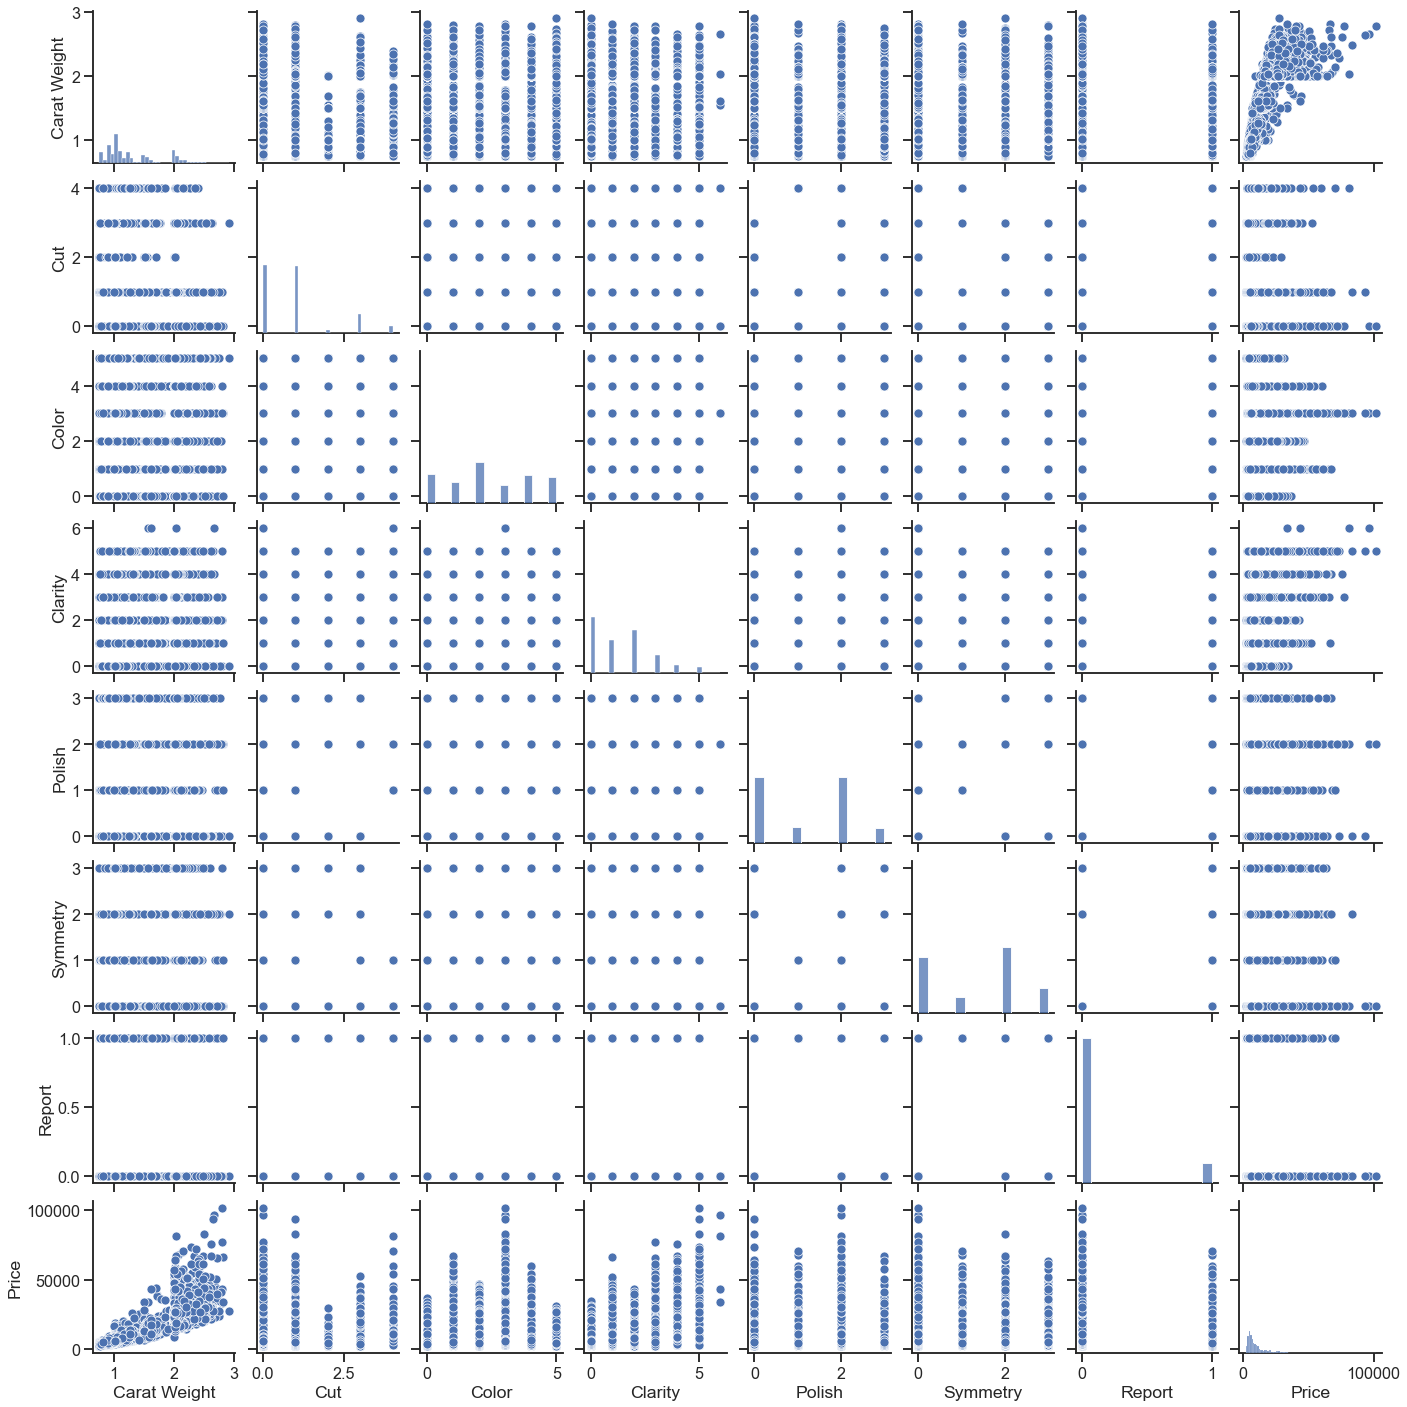

In [21]:
sns.set(context='talk', style='ticks', font_scale=0.98)
sns.pairplot(dataset)
plt.show()

由于数据的离散类型较大，所以绘制的图像看着非常工整，原因也很简单，当横纵坐标都是离散值时，绘制的图像只可能在几个特定位置出现数据点。所以这样的数据其实并不能得到很多信息。

- 不过，从图中还是可以得到一些信息的。
- 观察左下角的price-carat weight散点图，明显看到了数据存在正相关关系，说明钻石的价格与克拉重量有正相关关系。
- 观察左上角的carat weight分布图，发现钻石的重量是存在两个峰值的，就是说钻石存在小钻石类和大钻石类，也比较符合我们的认知：碎钻，整钻。
- 观察右下角的price分布图，发现钻石的分布区间明显在低价格部分，说明贵的钻石虽然有人买，但是大部分人还是穷人啊。

### 数据集划分
为了对未知数据进行预测，从原始数据集中保留了600条记录的样本。将总共6000条数据拆分为5400+600条。

- 模拟现实生活场景，总有些情况是没有遇到过的。

In [22]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (5400, 8)
Unseen Data For Predictions: (600, 8)


## 设置环境
使用setup()函数初始化pycaret中的环境。

在pycaret中执行任何其他功能之前，必须先调用setup()。
它具有两个必填参数：

    data：填入一个dataframe
    teraget：填入列名

当执行setup()时，PyCaret的推断算法将根据某些属性自动推断所有功能的数据类型,自动判断通常存在错误的可能。为了解决这个问题，在执行setup()之后，PyCaret将显示一个包含特征及其推断的数据类型的表。

    推断正确：Enter键
    推断错误：quit键

pycaret会自动执行一些预处理任务，对于不同数据类型，处理方式往往不同。

In [27]:
from pycaret.regression import *
exp_reg101 = setup(data = data, target = 'Price' ,fold_shuffle=True)

,Description,Value
0,session_id,4548
1,Target,Price
2,Original Data,"(5400, 8)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3779, 7)"


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

成功执行set()后，会打印包含一些重要信息的信息表。为了pycaret的通用性，所以显示了大量信息，但是绝大多数信息并没有在本次任务中使用。

## 创建模型

### 评估性能

在完成set()完成后比较所有模型以评估性能（对所有模型进行训练，因为无法确切判断需要使用哪种模型）

此功能训练模型库中的所有模型，并使用k值交叉验证对模型进行度量评估。

输出数据表显示出各种对模型的评价指标：
- average MAE，平均绝对误差
- MSE，均方误差
- RMSE，均方根误差
- R2，决定系数
- RMSLE，均方根对数误差
- MAPE（默认为10），平均绝对百分误差
- training time，训练时间

这些指标背后都存在着数学意义，每个指标都反映了模型的性能。可以参考[知乎评价指标解释](https://zhuanlan.zhihu.com/p/86120987?from_voters_page=true) 

这里有一个小技巧，除了R2以外的所有指标，数值越小表示模型效果越好,R2(小于1)则是数值越大越好。pycaret默认的是R2为评价模型的首要指标，我们也这样做，对模型评价，R2值接近1，意味着模型效果越好。

In [28]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,615.1563,1541740.5072,1223.2425,0.9853,0.0657,0.0491,0.2480
xgboost,Extreme Gradient Boosting,692.1030,2098263.6750,1420.1581,0.9802,0.0714,0.0530,0.1800
rf,Random Forest Regressor,752.6734,2436824.5614,1542.2100,0.9766,0.0819,0.0605,0.0820
et,Extra Trees Regressor,799.6988,2910129.2968,1681.6736,0.9722,0.0873,0.0645,0.0690
lightgbm,Light Gradient Boosting Machine,755.9311,2969853.5073,1698.3220,0.9713,0.0786,0.0574,0.0310
gbr,Gradient Boosting Regressor,885.5420,3124504.7873,1756.0182,0.9698,0.0938,0.0710,0.0240
dt,Decision Tree Regressor,926.3933,3586596.8065,1877.0572,0.9654,0.1030,0.0754,0.0050
lasso,Lasso Regression,2830.5540,21597956.1872,4604.9772,0.7938,0.5881,0.2903,0.2230
ridge,Ridge Regression,2828.9274,21597882.2622,4604.8746,0.7938,0.5873,0.2900,0.0040
br,Bayesian Ridge,2830.1919,21597772.7762,4604.9352,0.7938,0.5861,0.2902,0.0040


一行代码，训练和评估了19个模型！！！

数据表高亮了性能最高的模型。默认情况下，表格使用R2（从最高到最低）进行排序。

## 选择模型训练
model()函数显示了pycaret可以使用的回归模型。

In [29]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


根据模型评估的性能，以及模型的通用程度，我们选择以下三种模型进行进一步训练：

- CatBoost Regressor(效果最好，但是计算慢)
- Linear Regression(最基础)
- Random Forest（使用普遍）


### AdaBoost Regressor

In [30]:
ada = create_model('ada')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4240.2387,23767577.8850,4875.2003,0.7918,0.5203,0.6146
1,3985.4360,22107872.6962,4701.9010,0.7696,0.4756,0.5457
2,3524.0858,18332038.5203,4281.5930,0.7968,0.4320,0.4788
3,4222.8961,24235907.2673,4922.9978,0.8069,0.5033,0.5872
4,3843.7869,20220368.6407,4496.7064,0.7942,0.4573,0.5122
5,4155.7824,24404498.2537,4940.0909,0.8252,0.4723,0.5373
6,3828.1344,19628722.7542,4430.4314,0.7997,0.4948,0.5593
7,3808.8745,19583277.0037,4425.2997,0.7650,0.4525,0.5119
8,4321.5104,24542158.5714,4954.0043,0.7523,0.4928,0.5764
9,3968.4621,21192758.7109,4603.5594,0.7553,0.5091,0.5882


In [31]:
print(ada)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=4548)


### Light Gradient Boosting Machine

In [32]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,750.2662,4336669.2109,2082.4671,0.9620,0.0776,0.0560
1,658.5058,1742311.0609,1319.9663,0.9818,0.0702,0.0543
2,709.5882,2096327.1935,1447.8699,0.9768,0.0817,0.0575
3,778.1026,3688552.8080,1920.5605,0.9706,0.0749,0.0566
4,828.0856,3452812.7338,1858.1746,0.9649,0.0799,0.0593
5,880.8461,4378143.6866,2092.4014,0.9686,0.0751,0.0560
6,694.9811,1673633.0649,1293.6897,0.9829,0.0785,0.0589
7,744.6139,3475231.0879,1864.1972,0.9583,0.0832,0.0573
8,723.4666,2000836.9560,1414.5094,0.9798,0.0726,0.0536
9,790.8553,2854017.2710,1689.3837,0.9670,0.0929,0.0646


In [33]:
print(lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=4548, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### Decision Tree

In [34]:
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,939.3900,4603861.6232,2145.6611,0.9597,0.1010,0.0733
1,877.2769,3424999.2867,1850.6754,0.9643,0.1002,0.0736
2,861.2486,2607871.0233,1614.8904,0.9711,0.1042,0.0765
3,965.9306,4129138.8103,2032.0283,0.9671,0.1053,0.0790
4,951.9570,3080102.7383,1755.0221,0.9686,0.1052,0.0772
5,1062.7504,5636102.9218,2374.0478,0.9596,0.0961,0.0710
6,945.9383,3576810.6947,1891.2458,0.9635,0.1052,0.0764
7,877.9079,3086445.1936,1756.8282,0.9630,0.1070,0.0771
8,854.5106,2078910.5822,1441.8428,0.9790,0.0960,0.0720
9,927.0225,3641725.1907,1908.3305,0.9580,0.1103,0.0778


In [35]:
print(dt)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, random_state=4548,
                      splitter='best')


注意，所有模型的平均分数与 compare_models() 中打印的分数相匹配。 这是因为在 compare_models() 分数网格中打印的指标是所有 CV 折叠的平均分数。 与 compare_models() 类似，如果要将 fold 参数从默认值 10 更改为不同的值，则可以使用 fold 参数。 例如： create_model('dt', fold = 5) 使用 5 折交叉验证创建决策树。

## 调整模型

使用create_model函数创建模型时，是使用默认的超参数来训练模型的。在选定了使用模型后，为了提高精度，我们需要调整超参数，pycaret提供了tune_model函数，一键调整超参数。
### Adaboost

In [36]:
tuned_ada = tune_model(ada)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2687.7681,15636167.9394,3954.2595,0.8630,0.3120,0.2948
1,2540.9421,14116603.0795,3757.2068,0.8529,0.2997,0.2809
2,2602.4651,13980668.8695,3739.0733,0.8451,0.3124,0.3019
3,2660.9771,17182871.3022,4145.2227,0.8631,0.2977,0.2751
4,2501.7467,12738953.8171,3569.1671,0.8703,0.2863,0.2640
5,2688.0508,19487036.6670,4414.4124,0.8604,0.2857,0.2637
6,2825.7394,16555579.9002,4068.8549,0.8311,0.3200,0.2985
7,2391.9181,12845093.8087,3584.0053,0.8459,0.2886,0.2649
8,2757.4823,16506294.4555,4062.7939,0.8334,0.2875,0.2685
9,2680.6500,13389087.3059,3659.1102,0.8454,0.3266,0.3155


### Light Gradient Boosting Machine

In [37]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
            'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
            'learning_rate': np.arange(0.1,1,0.1)
            }

In [38]:
tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,793.5786,3075349.5026,1753.6674,0.9731,0.0819,0.0600
1,683.8891,1645790.5805,1282.8837,0.9828,0.0745,0.0570
2,730.4522,1738365.2958,1318.4708,0.9807,0.0841,0.0615
3,855.9772,3553705.4342,1885.1274,0.9717,0.0816,0.0631
4,776.4386,2321813.1726,1523.7497,0.9764,0.0795,0.0602
5,947.4609,4430551.6676,2104.8876,0.9683,0.0787,0.0594
6,755.8866,1536094.1639,1239.3927,0.9843,0.0899,0.0652
7,758.9235,2388549.2902,1545.4932,0.9713,0.0914,0.0647
8,760.2376,2269432.8620,1506.4637,0.9771,0.0826,0.0581
9,794.8690,2231138.9301,1493.6997,0.9742,0.0844,0.0634


In [39]:
print(tuned_lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=160, objective=None,
              random_state=4548, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


### Decision Tree

In [40]:
tuned_dt = tune_model(dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,873.4480,3592916.6131,1895.4990,0.9685,0.0946,0.0684
1,883.7948,3728152.2292,1930.8424,0.9611,0.1007,0.0732
2,820.3540,2580097.8445,1606.2683,0.9714,0.0940,0.0689
3,975.0307,4446766.8206,2108.7358,0.9646,0.1044,0.0772
4,905.8359,2579396.4502,1606.0500,0.9737,0.1009,0.0734
5,930.0677,3907663.1295,1976.7810,0.9720,0.0892,0.0660
6,881.7188,3484888.0760,1866.7855,0.9644,0.0994,0.0704
7,824.3176,2713216.2593,1647.1843,0.9674,0.1001,0.0703
8,791.5782,2150273.6148,1466.3811,0.9783,0.0895,0.0663
9,887.9693,3724899.8140,1930.0000,0.9570,0.1012,0.0734


## 结果绘图

在模型训练完成后，使用plot_model()函数分析不同方面的性能，例如残差图，预测误差图，特征重要性图等。

### 残差图
残差在数理统计中是指真实值与预测值之间的差。

残差图是指以某种残差为纵坐标，以其他适宜的量为横坐标的散点图。
该残差图的横坐标为预测值，纵坐标为残差，看出残差并没有随着预测范围的改变而出现极大变化，比较均匀地分布在预测价格的横坐标上。这反映了模型在预测上并没有”偏科“，对所有价格的钻石都有比较合理的预测结果。
- 特别需要注意的是，蓝色点为训练集，绿色点为测试集，图中明显看出，蓝色点的残差更加小，这是机器学习结果的常态，即训练集效果优于测试集效果。
- 有兴趣的同学可以思考一下为什么会这样？
- 会不会存在测试集效果和训练集效果一样好的情况？
- 是不是训练的残差越小越好。

这些问题的思考有助于同学们加深对机器学习的理解。

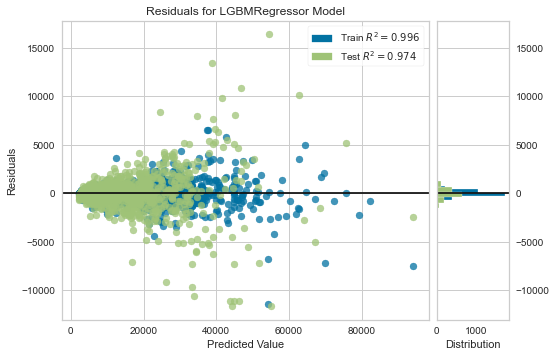

In [41]:
plot_model(tuned_lightgbm)

### 预测偏差

In [ ]:
plot_model(tuned_lightgbm, plot = 'error')

### 预测重要性图

展示了数据不同特征对预测结果的重要性。由图显示，钻石的克拉重量对钻石价格的重要性最大。

In [ ]:
plot_model(tuned_lightgbm, plot='feature')

## 预测模型

还记得最初留下的600个数据嘛？predict_model()函数将模型在看不见的数据集上进行预测。 

我们将传递data_unseen参数。data_unseen是在任务开始时创建的变量，包含从未暴露给PyCaret的原始数据集的10％（600个样本）。 

In [ ]:
unseen_predictions = predict_model(tuned_lightgbm, data=data_unseen)
unseen_predictions.head(20)

Label列添加到data_unseen表的最后一列，label列是使用Random Forest模型对特征进行预测结果，可以发现label列数值与price列数值是非常接近的。

计算预测值与真实值的R2

In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.Price, unseen_predictions.Label, 'R2')